<a href="https://colab.research.google.com/github/nou321/PFE_Nour/blob/main/Cnn_test_etudiants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import numpy as np 
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from keras.backend import dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
csv_path='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/Anonymized_images.xlsx'
augmented='/content/drive/MyDrive/Colab Notebooks/Pfe/augmented'
nsj_path='/content/drive/MyDrive/Colab Notebooks/Pfe/augmented/Data/nsj'
sj_path='/content/drive/MyDrive/Colab Notebooks/Pfe/augmented/Data/sj'
aug_nsj_path='/content/drive/MyDrive/Colab Notebooks/Pfe/augmented/augmented/new_nsj'
aug_sj_path='/content/drive/MyDrive/Colab Notebooks/Pfe/augmented/augmented/new_sj'
aug_path='/content/drive/MyDrive/Colab Notebooks/Pfe/augmented/augmented'

# image génerator

In [32]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
       rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
   

i = 0
for batch in datagen.flow_from_directory(directory=sj_path, batch_size=16,
                                         save_to_dir=aug_sj_path,
                                         save_prefix='sj',
                                         target_size=(64,64), save_format='jpg'):
    i += 1
    if i > 99:
        break
  

Found 115 images belonging to 2 classes.


In [33]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

i = 0
for batch in datagen.flow_from_directory(directory=nsj_path, batch_size=16,
                                         save_to_dir=aug_nsj_path,
                                         save_prefix='sj',
                                         target_size=(64,64), save_format='jpg'):
    i += 1
    if i > 99:
        break

Found 110 images belonging to 2 classes.


# Dataset

## importing dataset

In [47]:
img_size = 64
batch_size = 10

In [36]:
#making a dataset from the Rsized images folder
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(aug_path,shuffle=True, image_size=(img_size,img_size),batch_size = batch_size)

Found 3016 files belonging to 2 classes.


In [37]:
class_names = dataset.class_names

In [38]:
class_names[1]

'new_sj'

In [39]:
class_names[0]

'new_nsj'

In [40]:
len(dataset)

302

## visualisation

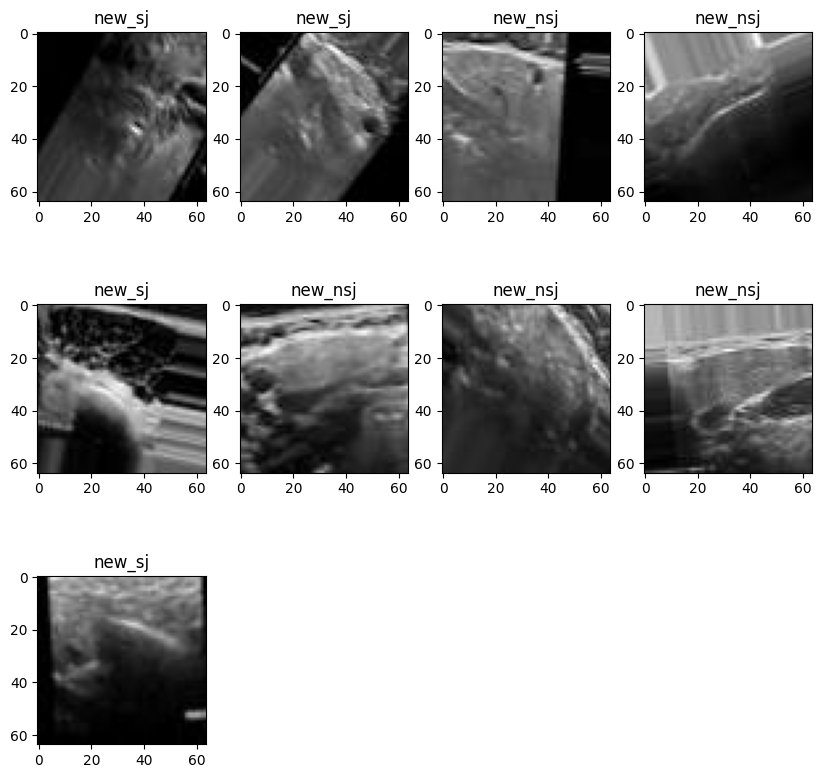

In [41]:
#ploting some images with their classes
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 10))
for image_batch , label_batch in dataset.take(1):
   for i in range(9):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        
          #  print(image_batch.shape)


# Split dataset

In [48]:
len(dataset)

302

In [ ]:
80% ==> training 
20% ==> 10% validation, 10% test

SyntaxError: ignored

In [49]:
train_size = 0.8
len(dataset)*train_size

241.60000000000002

In [50]:
train_ds = dataset.take(20)
len(train_ds)

20

In [51]:
test_ds = dataset.skip(20)
len(test_ds)

282

In [52]:
val_size=0.1
len(dataset)*val_size

30.200000000000003

In [53]:
val_ds = test_ds.take(3)
len(val_ds)

3

In [54]:
test_ds = test_ds.skip(3)
len(test_ds)

279

In [55]:
#splitting the data between train, test and valid
def get_dataset_partitions_tf(ds,  train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size=len(ds)
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [56]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [57]:
len(train_ds)

241

In [58]:
len(val_ds)

30

In [59]:
len(test_ds)

31

# CNN

In [60]:

CHANNELS = 3

input_shape = ( img_size, img_size, CHANNELS)
model = Sequential()
model.add(Conv2D(32,(3,3),activation='relu', input_shape = input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, kernel_size = (3,3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, kernel_size = (3,3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(8,(3,3),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.build(input_shape=input_shape)

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 16)         0

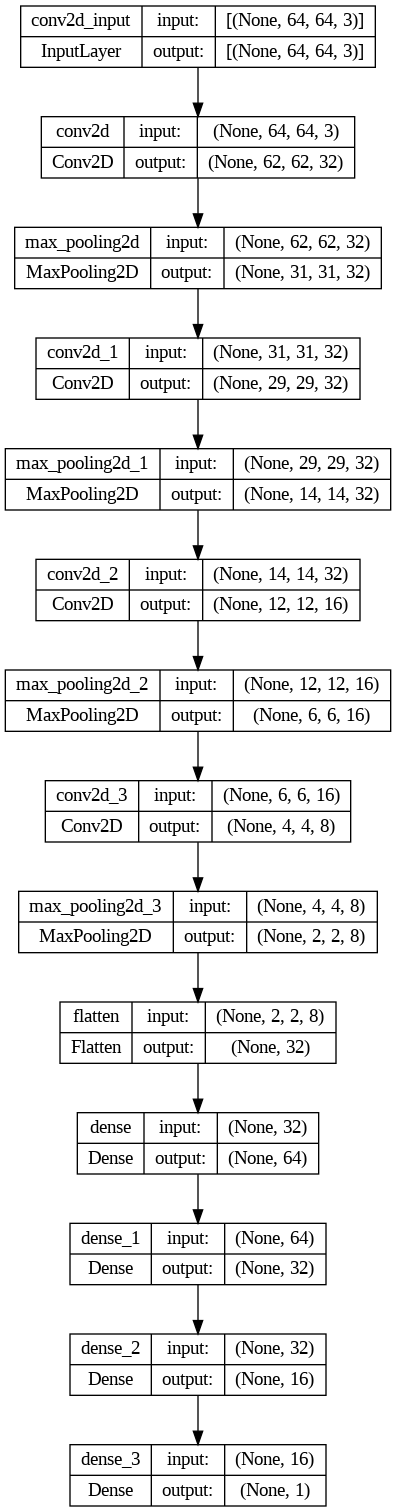

In [62]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['Recall']
)

In [64]:
EPOCHS=150

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/150
241/241 [==============================] - 22s 28ms/step - loss: 0.7682 - recall: 0.5138 - val_loss: 0.6734 - val_recall: 0.6689
Epoch 2/150
241/241 [==============================] - 6s 16ms/step - loss: 0.6735 - recall: 0.5130 - val_loss: 0.6313 - val_recall: 0.4370
Epoch 3/150
241/241 [==============================] - 7s 20ms/step - loss: 0.6515 - recall: 0.4644 - val_loss: 0.6436 - val_recall: 0.4575
Epoch 4/150
241/241 [==============================] - 7s 19ms/step - loss: 0.6487 - recall: 0.4158 - val_loss: 0.6426 - val_recall: 0.5520
Epoch 5/150
241/241 [==============================] - 7s 15ms/step - loss: 0.6410 - recall: 0.4439 - val_loss: 0.6275 - val_recall: 0.4041
Epoch 6/150
241/241 [==============================] - 9s 26ms/step - loss: 0.6338 - recall: 0.4905 - val_loss: 0.7017 - val_recall: 0.6879
Epoch 7/150
241/241 [==============================] - 6s 16ms/step - loss: 0.6463 - recall: 0.4825 - val_loss: 0.6649 - val_recall: 0.4722
Epoch 8/150
241/241

# evaluation

dict_keys(['loss', 'recall', 'val_loss', 'val_recall'])


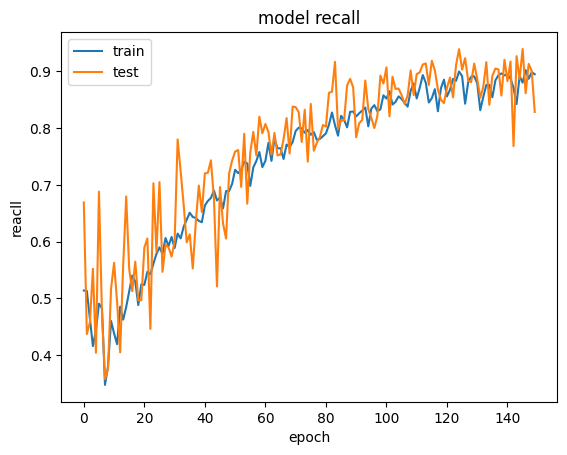

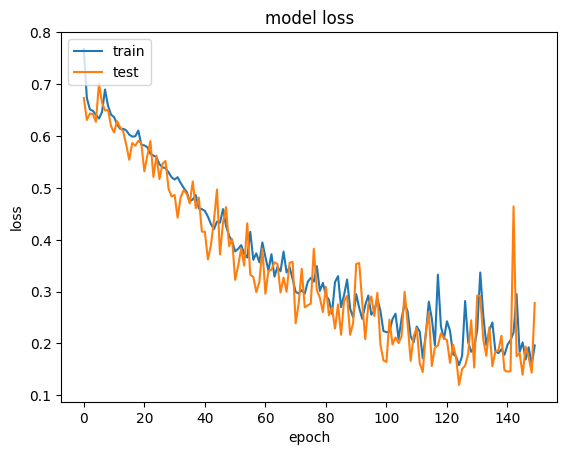

In [65]:
print(history.history.keys())
#recall 
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('reacll')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [66]:
#runing the model on a new dataset(test_Ds)
scores = model.evaluate(test_ds)

31/31 [==============================] - 3s 3ms/step - loss: 0.2313 - recall: 0.8794


first img predicted
first image's actual label  new_nsj
1/1 [==============================] - 0s 30ms/step
[0.04847605]
predicted: nsj


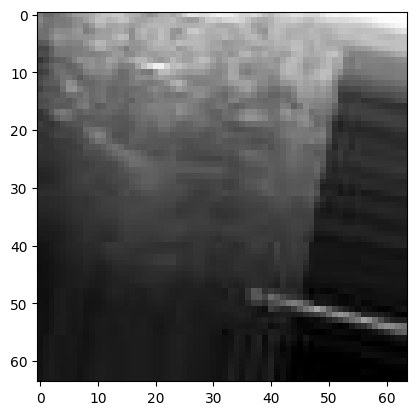

In [71]:
import numpy as np
for images_batch , labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype("uint8")
  first_label = labels_batch[0].numpy()
 
  print("first img predicted")
  plt.imshow(first_image)

  print("first image's actual label ",class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print(batch_prediction[0])
  if(batch_prediction[0] > 0.5):
    print("predicted: sj")
  else :
    print("predicted: nsj")   
  

In [72]:
#a function that takes image as input and turn the predicted class and confidence
def predict(model, img):
   img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
   img_array = tf.expand_dims(img_array, 0)

   predictions = model.predict(img_array)
   if(predictions[0] > 0.5):
     predicted_class= class_names[1]
   else:
     predicted_class= class_names[0]  

   #predicted_class = class_names[np.argmax(predictions[0])]
  
   return predicted_class





1/1 [==============================] - 0s 19ms/step


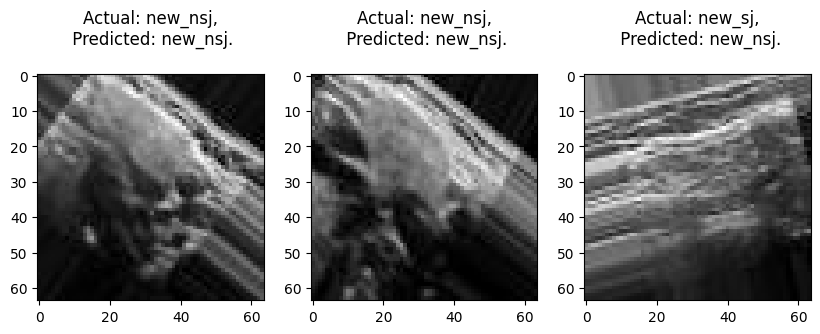

In [73]:
#plotting the images with it's classes and confidence
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
   for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n ")

In [ ]:
model_version=2
model.save(f"/gdrive/MyDrive/stage PFE/models{model_version}")